In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/monoclonal-gammopathy-data/mgus2.csv
/kaggle/input/monoclonal-gammopathy-data/mgus1.csv


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

In [3]:
df1= pd.read_csv('/kaggle/input/monoclonal-gammopathy-data/mgus1.csv')
df1 = df1.drop('Unnamed: 0', axis=True)
df2= pd.read_csv('/kaggle/input/monoclonal-gammopathy-data/mgus2.csv')

# Data Summary and Outcomes

In [4]:
def summary(df):
    # Print the shape of the DataFrame
    print(f'data shape: {df.shape}')  
    # Create a summary DataFrame
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    # Calculate the number of missing values
    summ['#missing'] = df.isnull().sum().values 
    # Calculate the percentage of missing values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    # Calculate the number of unique values
    summ['#unique'] = df.nunique().values
    # Create a descriptive DataFrame
    desc = pd.DataFrame(df.describe(include='all').transpose())
    # Add the minimum, maximum, and first three values to the summary DataFrame
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    # Return the summary DataFrame
    return summ

In [5]:
summary(df1)

data shape: (305, 14)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.000000,241,1.0,241.0,1,2,2
age,int64,0,0.000000,53,34.0,90.0,78,73,73
sex,object,0,0.000000,2,NaN,NaN,female,female,female
dxyr,int64,0,0.000000,17,56.0,73.0,68,66,66
pcdx,object,177,58.032787,4,NaN,NaN,NaN,LP,LP
alb,float64,41,13.442623,26,1.8,5.1,2.8,NaN,NaN
creat,float64,55,18.032787,19,0.6,6.4,1.2,NaN,NaN
hgb,float64,2,0.655738,66,7.4,16.6,11.5,NaN,NaN
mspike,float64,0,0.000000,23,0.3,3.2,2.0,1.3,1.3
stop,float64,0,0.000000,300,6.0,14325.0,748.0,1310.0,6751.0


- Dataset Shape: The dataset contains 305 rows and 14 columns.

- Data Types: The dataset includes various data types such as int64, object, float64.

- Missing Values: Some columns have missing values. The "pcdx" column has 177 missing values (58.03% missing), "alb" column has 41 missing values (13.44% missing), "creat" column has 55 missing values (18.03% missing), and "hgb" column has 2 missing values (0.66% missing).

- Unique Values: The "id" column has 241 unique values, "age" column has 53 unique values, "sex" column has 2 unique values, "dxyr" column has 17 unique values, "pcdx" column has 4 unique values, "alb" column has 26 unique values, "creat" column has 19 unique values, "hgb" column has 66 unique values, and "mspike" column has 23 unique values.

- Range of Values: The "id" column ranges from 1 to 241, "age" column ranges from 34 to 90, "dxyr" column ranges from 56 to 73, "alb" column ranges from 1.8 to 5.1, "creat" column ranges from 0.6 to 6.4, "hgb" column ranges from 7.4 to 16.6, "mspike" column ranges from 0.3 to 3.2, and "stop" column ranges from 6.0 to 14325.0.

# Fixing Missing values

In [6]:
df1['pcdx'].fillna('Unknown', inplace=True)
df1['alb'].fillna(df1['alb'].mean(), inplace=True)
df1['creat'].fillna(df1['creat'].mean(), inplace=True)
df1['hgb'].fillna(df1['hgb'].mean(), inplace=True)

# Finding and fixing Outliars

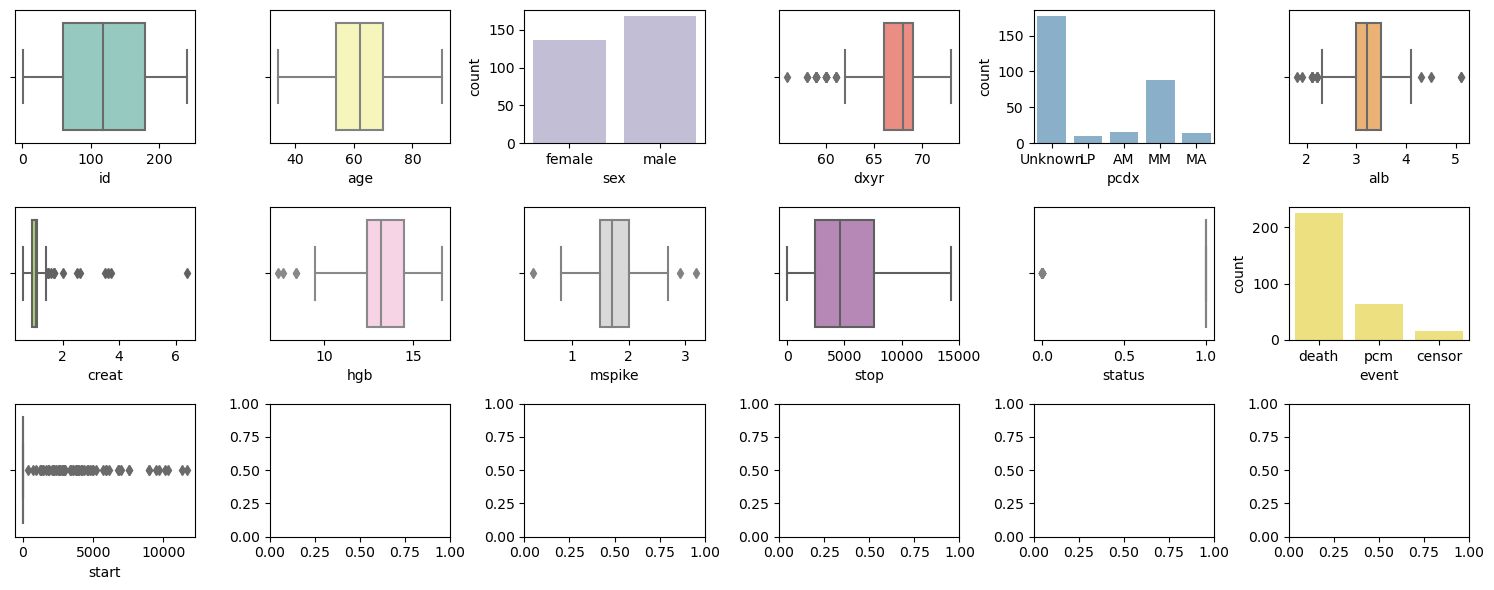

In [7]:
def boxplots(df):
    cols = df.columns[:-1]
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)
    
    # Define a colorful palette
    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    for idx, col in enumerate(cols):
        i = idx // m
        j = idx % m
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
        else:
            sns.boxplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
    
    plt.tight_layout()
    plt.show()

boxplots(df1)

In [8]:
def outliers_removal(df, col):
    if df[col].dtype != 'object':
        perc = np.percentile(df[col], [0, 25, 50, 75, 100])
        iqr = perc[3] - perc[1]
        _min = perc[1] - 1.5 * iqr
        _max = perc[3] + 1.5 * iqr
        df.loc[df[col] > _max, col] = _max
        df.loc[df[col] < _min, col] = _min
    return df

cols = [col for col in df1.columns if col != 'Unnamed: 0']
for col in cols:
    df1 = outliers_removal(df1, col)

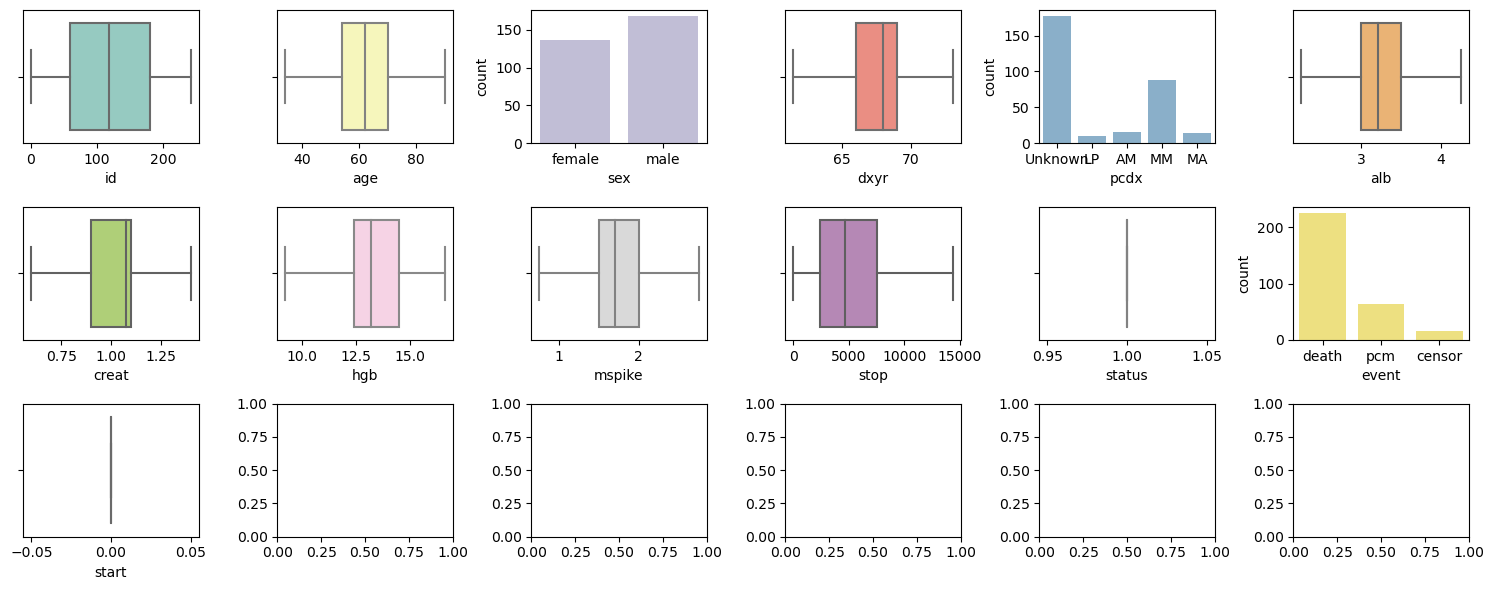

In [9]:
boxplots(df1)

# Visualization- Sex, Age and Srops

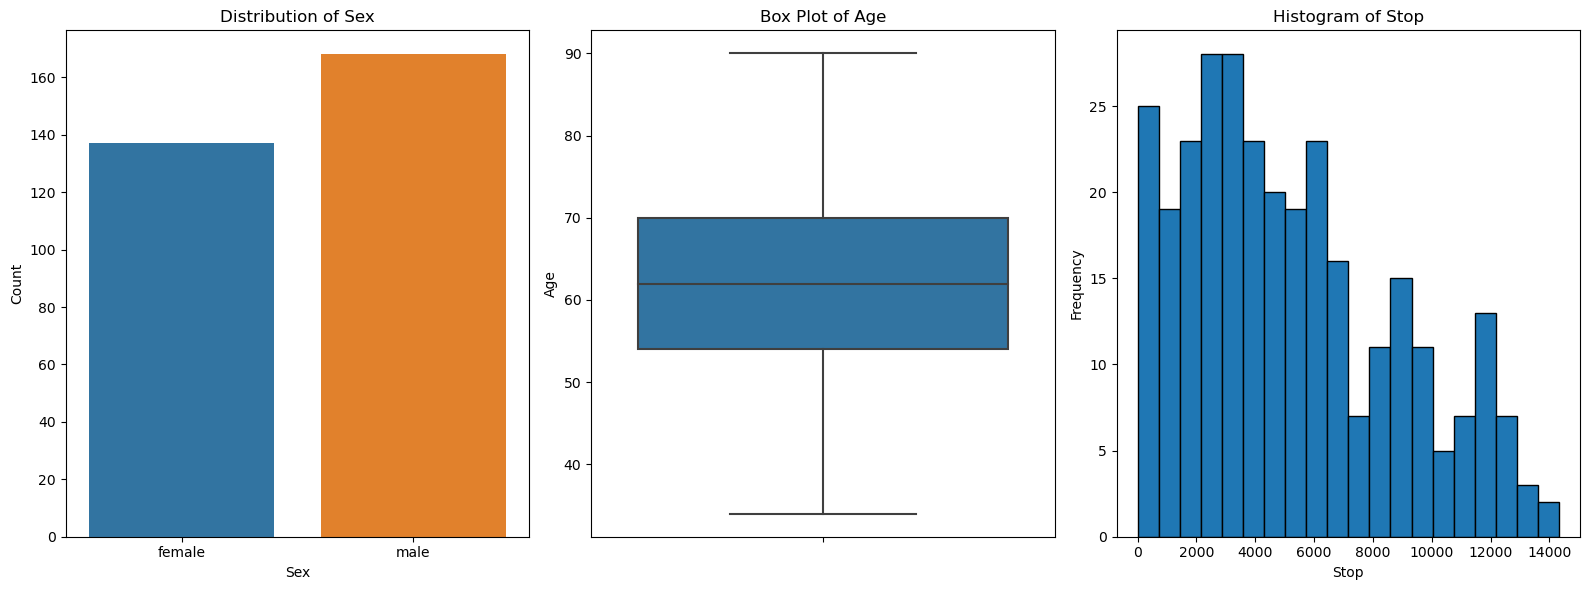

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

sns.countplot(data=df1, x='sex', ax=axes[0])
axes[0].set_title('Distribution of Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

sns.boxplot(data=df1, y='age', ax=axes[1])
axes[1].set_title('Box Plot of Age')
axes[1].set_ylabel('Age')

axes[2].hist(df1['stop'], bins=20, edgecolor = 'black')
axes[2].set_title('Histogram of Stop')
axes[2].set_xlabel('Stop')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Model: 73% acc

In [11]:
features = ['age', 'sex', 'alb', 'creat', 'hgb', 'mspike']
target = 'event'

X = df1[features]
y = df1[target]

X = X.fillna(X.mean())

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7377049180327869


/tmp/ipykernel_20/1180297473.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X = X.fillna(X.mean())


# Feature Importance

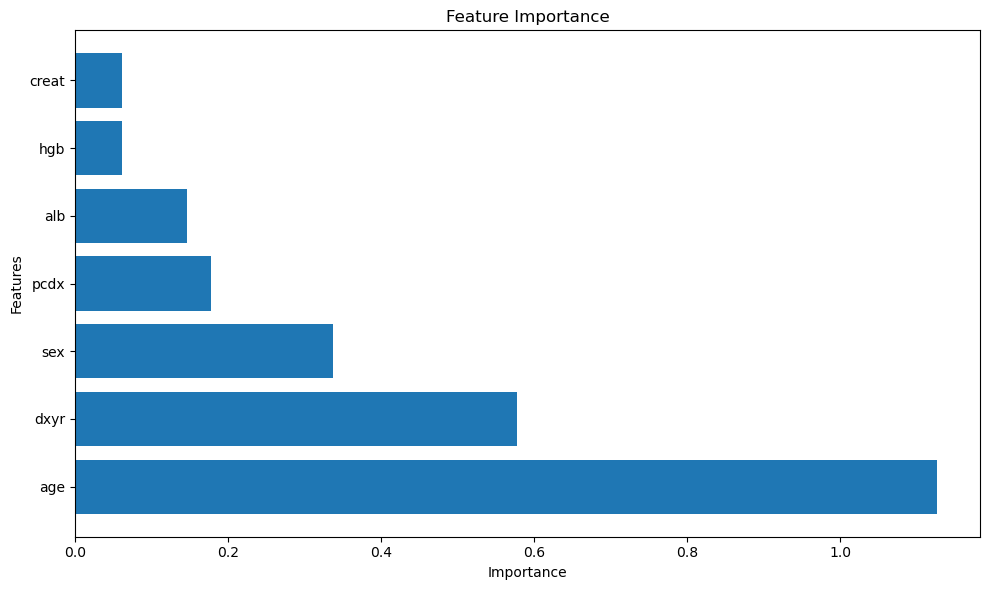

In [12]:
feature_importance = np.abs(model.coef_[0])
feature_names = df1.drop(['event', 'id'], axis=1).columns
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(feature_importance)), sorted_feature_names)  # Corrected line
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()